# Fair Housing Project
### Assigned by Bob Gradeck of the Western PA Data Conservancy
Tara Schroth, Stephen Vandrak, Gloria Givler, Annie Goodwin  

### Project Objective
Currently, the affordable housing initiative struggles to place property bids quickly, due to bureaucracy inherent in the organization (working with government resources, etc). Our objective with this project is to establish a list of property owners that may be selling multi-unit properties in the near future. That way, the affordable housing initiative can reach out proactively to these owners and potentially strike a deal to purchase properties before they hit the market.

In [15]:
#import all necessary modules and packages
import pandas as pd
pd.set_option('display.max_rows', None)
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import string
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")
!pip install plotly
import plotly.express as px

## Importing, cleaning, and merging the datasets

After reading in the sales and assessments datasets and dropping unwanted columns, we wanted to narrow the assessments dataset down to only the properties we are interested in. 

We decided to filter by the feature "USEDESC" (use description). We weren't interested in single-family homes, multi-family homes such as duplexes, condominum units, or any other types of residential properties that could not easily be converted to low-income housing. We decided that we were only interested in properties with the following use descriptions:
- APART:40+ UNITS
- APART:20-39 UNITS
- APART: 5-19 UNITS
- DWG APT CONVERSION


In [16]:
# Read in sales data and look at first 5 rows
sales=pd.read_csv('SalesData.csv', low_memory=False)
sales.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,...,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,1075F00108000000,4720,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,...,Hampton,2012-09-27,2012-09-27,120000.0,15020,356,3,LOVE AND AFFECTION SALE,DE,DEED
1,0011A00237000000,0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,...,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,00002,2,CITY TREASURER SALE,TS,TREASURER DEED
2,0011J00047000000,1903,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,...,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,003,2,CITY TREASURER SALE,TS,TREASURER DEED
3,0113B00029000000,479,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,...,Bellevue,2017-03-27,2017-03-06,0.0,16739,166,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED
4,0119S00024000000,5417,,NaN,NATRONA,WAY,NaN,NaN,PITTSBURGH,PA,...,10th Ward - PITTSBURGH,2015-02-04,2015-02-04,27541.0,TR15,00059,GV,GOVERNMENT SALE,TS,TREASURER DEED


In [17]:
# Convert sale date from string to date
sales['SALEDATE']=pd.to_datetime(sales['SALEDATE'])

In [18]:
# Read in assessments data and look at first 5 rows
#change path to work with your file setup
path='C:\\Users\\Tara\\OneDrive - University of Pittsburgh\\FALL 2022\\ENGR 1171\\Project Housing Data\\'

assessment=pd.read_csv(path+'AssessmentData.csv', low_memory=False)
assessment.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYCITY,PROPERTYSTATE,PROPERTYUNIT,PROPERTYZIP,MUNICODE,MUNIDESC,...,HALFBATHS,HEATINGCOOLING,HEATINGCOOLINGDESC,FIREPLACES,BSMTGARAGE,FINISHEDLIVINGAREA,CARDNUMBER,ALT_ID,TAXYEAR,ASOFDATE
0,0001G00104000000,210,,BLVD OF THE ALLIES,PITTSBURGH,PA,,15222.0,101,1st Ward - PITTSBURGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,01-OCT-22
1,0001G00106000000,106,,MARKET ST,PITTSBURGH,PA,,15222.0,101,1st Ward - PITTSBURGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,01-OCT-22
2,0001G00107000000,104,,MARKET ST,PITTSBURGH,PA,,15222.0,101,1st Ward - PITTSBURGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,01-OCT-22
3,0001G00109000000,100,,MARKET ST,PITTSBURGH,PA,,15222.0,101,1st Ward - PITTSBURGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,01-OCT-22
4,0001G00111000000,161,,1ST AVE,PITTSBURGH,PA,,15222.0,101,1st Ward - PITTSBURGH,...,1.0,B,Central Heat with AC,NaN,NaN,2011.0,1.0,NaN,2022,01-OCT-22


In [19]:
# Drop unwanted columns and look at first 5 rows
assessment=assessment[['PARID','PROPERTYHOUSENUM','PROPERTYFRACTION','PROPERTYADDRESS','PROPERTYUNIT','MUNIDESC','OWNERDESC','CLASSDESC', 
'USEDESC', 'LOTAREA','HOMESTEADFLAG','FARMSTEADFLAG','ABATEMENTFLAG','SALEDATE','SALEPRICE','SALEDESC','PREVSALEDATE','PREVSALEPRICE',
 'PREVSALEDATE2','PREVSALEPRICE2','CHANGENOTICEADDRESS1','CHANGENOTICEADDRESS2','CHANGENOTICEADDRESS3','CHANGENOTICEADDRESS4',
'STYLEDESC','STORIES','YEARBLT','CDUDESC',
]]
assessment.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,PREVSALEDATE2,PREVSALEPRICE2,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC
0,0001G00104000000,210,,BLVD OF THE ALLIES,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,PARKING GARAGE/LOTS,2280,...,12-26-1990,50000.0,2020 SMALLMAN ST STE 301,,PITTSBURGH PA,15222,NaN,NaN,NaN,NaN
1,0001G00106000000,106,,MARKET ST,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,RETL/OFF OVER,4680,...,NaN,NaN,2020 SMALLMAN ST STE 301,,PITTSBURGH PA,15222,NaN,NaN,NaN,NaN
2,0001G00107000000,104,,MARKET ST,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,"RESTAURANT, CAFET AND/OR BAR",2400,...,04-14-1997,1.0,104 MARKET ST,,PITTSBURGH PA,15222,NaN,NaN,NaN,NaN
3,0001G00109000000,100,,MARKET ST,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,"RESTAURANT, CAFET AND/OR BAR",4800,...,04-14-1997,1.0,100 MARKET ST,,PITTSBURGH PA,15222,NaN,NaN,NaN,NaN
4,0001G00111000000,161,,1ST AVE,,1st Ward - PITTSBURGH,REGULAR,RESIDENTIAL,SINGLE FAMILY,995,...,10-14-2015,1754901.0,161 1ST AVE,,PITTSBURGH PA,15222,TOWNHOUSE,1.0,2015.0,EXCELLENT


In [20]:
# Narrow it down to properties we’re interested in
# Filter by USEDESC (see above explanation of choices)
assessment=assessment.loc[
    (assessment['USEDESC'].isin(['APART:40+ UNITS','APART:20-39 UNITS','APART:5-19 UNITS','DWG APT CONVERSION']))
]
assessment.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,PREVSALEDATE2,PREVSALEPRICE2,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC
68,0001G00043000000,300,,LIBERTY AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,54798,...,NaN,NaN,95 W BEAU ST STE 600,,WASHINGTON PA,15301,NaN,NaN,NaN,NaN
203,0001H00363000000,319,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,8407,...,NaN,NaN,200 DRYDEN RD STE 2000,,DRESHER PA,19025,NaN,NaN,NaN,NaN
206,0001H0037000AU00,301,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,0,...,NaN,NaN,425 6TH AVE STE 950,,PITTSBURGH PA,15219,NaN,NaN,NaN,NaN
330,0002G00013000000,1030,,5TH AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:20-39 UNITS,8064,...,11-10-1985,1.0,1717 ARCH AVE STE 3820,,PHILADELPHIA PA,19103,NaN,NaN,NaN,NaN
461,0002J00260000000,615,-625,2ND AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,28919,...,08-19-2004,10.0,125 HIGH ST STE 2111,ATTN: SCOTT SPELFOGEL,BOSTON MA,02110,NaN,NaN,NaN,NaN


In [22]:
# Merge the two datasets
# Pull the latest sale date for each property (Tara’s code)
salesgrouped=sales[['PARID','SALEDATE']].groupby('PARID').agg({'SALEDATE':'max'}).reset_index().rename(columns={'SALEDATE':'FINALSALEDATE'})
df=pd.merge(assessment,salesgrouped,how='left',on='PARID')

## Determining the owners that have purchased the most properties in the past 2 years

We wanted to determine who has purchased the most properties in the past 2 years, with the goal of seeing which companies are currently growing their real-estate portfolios. They are less likely to be selling a lot of properties.

In [23]:
# Filter to last 2 years of sales only, look at first 5 rows
last2years=df.loc[df['FINALSALEDATE']>pd.Timestamp('2020-09-22 00:00:00')]
last2years.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,PREVSALEPRICE2,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC,FINALSALEDATE
26,0025N00013000000,2404,,RAILROAD ST,,2nd Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,31755,...,200000.0,430 PARK AVE STE 201,,NEW YORK NY,10022,NaN,NaN,NaN,NaN,2021-08-27
49,0028F00185000000,3413,-3435,FORBES AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,38111,...,3450000.0,1849 GREEN BAY RD FL 4,,HIGHLAND PARK IL,60035,NaN,NaN,NaN,NaN,2022-04-13
71,0052J00019000000,4601,,5TH AVE,,4th Ward - PITTSBURGH,REGULAR-ETAL,COMMERCIAL,APART:40+ UNITS,31380,...,NaN,1239 MURDOCH RD,,PITTSBURGH PA,15217,NaN,NaN,NaN,NaN,2022-07-01
72,0052J00138000000,4614,-4630,5TH AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,40000,...,NaN,800 WESTCHESTER AVE STE N-349,,PORT CHESTER NY,10573,NaN,NaN,NaN,NaN,2021-04-15
73,0028S00136000000,3408,,PARKVIEW AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,38000,...,1250000.0,1101 S CAPITAL OF TEXAS HWY STE B-220,,AUSTIN TX,78746,NaN,NaN,NaN,NaN,2021-04-06


In [24]:
# Find owners who have purchased at least 3 multiunit properties in the last 2 years and look at df
pd.options.mode.chained_assignment = None  # default='warn'
last2years['OwnerInfo']=last2years['CHANGENOTICEADDRESS1'].astype(str)+' '+last2years['CHANGENOTICEADDRESS2'].astype(str)+' '+last2years['CHANGENOTICEADDRESS3'].astype(str)+' '+last2years['CHANGENOTICEADDRESS4'].astype(str)
buyersofmany=last2years[['PARID','OwnerInfo']].drop_duplicates().groupby('OwnerInfo').size().reset_index(name='NumPropertiesBought')
buyersofmany=buyersofmany.loc[(~buyersofmany['OwnerInfo'].isna())&(buyersofmany['NumPropertiesBought']>2)]
last2years.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC,FINALSALEDATE,OwnerInfo
26,0025N00013000000,2404,,RAILROAD ST,,2nd Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,31755,...,430 PARK AVE STE 201,,NEW YORK NY,10022,NaN,NaN,NaN,NaN,2021-08-27,430 PARK AVE STE 201 NEW YORK NY 10022
49,0028F00185000000,3413,-3435,FORBES AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,38111,...,1849 GREEN BAY RD FL 4,,HIGHLAND PARK IL,60035,NaN,NaN,NaN,NaN,2022-04-13,1849 GREEN BAY RD FL 4 HIGHLAND PARK IL ...
71,0052J00019000000,4601,,5TH AVE,,4th Ward - PITTSBURGH,REGULAR-ETAL,COMMERCIAL,APART:40+ UNITS,31380,...,1239 MURDOCH RD,,PITTSBURGH PA,15217,NaN,NaN,NaN,NaN,2022-07-01,1239 MURDOCH RD PITTSBURGH PA 15217
72,0052J00138000000,4614,-4630,5TH AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,40000,...,800 WESTCHESTER AVE STE N-349,,PORT CHESTER NY,10573,NaN,NaN,NaN,NaN,2021-04-15,800 WESTCHESTER AVE STE N-349 PORT CHEST...
73,0028S00136000000,3408,,PARKVIEW AVE,,4th Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,38000,...,1101 S CAPITAL OF TEXAS HWY STE B-220,,AUSTIN TX,78746,NaN,NaN,NaN,NaN,2021-04-06,1101 S CAPITAL OF TEXAS HWY STE B-220 AUS...


In [25]:
# Group by the owner to get a list of owners
print('There are', len(buyersofmany), 'owners that have purchased at least three multiunit residential properties in the past 2 years')
buyersofmany.sort_values(['NumPropertiesBought'],ascending=[False])

# Owner's contact info (phone number/primary residence) is not available in the dataset

There are 7 owners that have purchased at least three multiunit residential properties in the past 2 years


,OwnerInfo,NumPropertiesBought
32,240 S MAIN ST STE 2300 NAZARETH PA 18064,15
5,1 S BROAD ST STE 1900 PHILADELPHIA PA 1...,5
48,429 FORBES AVE STE 1500 PITTSBURGH PA ...,5
28,2116 MERRIMAN WAY PITTSBURGH PA 15203,4
64,999 WATERSIDE DR STE 2300 NORFOLK VA 2...,4
20,1608 ROUTE 88 STE 200 BRICK NJ 08724,3
33,25 OAK HILL RD CHAPPAQUA NY 10514,3


## Determining the owners that currently own the most properties

We wanted to determine who currently owns the most properties, based on the property assessments.

In [26]:
# Look at all data we have
alltime=df
alltime.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,PREVSALEPRICE2,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC,FINALSALEDATE
0,0001G00043000000,300,,LIBERTY AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,54798,...,NaN,95 W BEAU ST STE 600,,WASHINGTON PA,15301,NaN,NaN,NaN,NaN,NaT
1,0001H00363000000,319,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,8407,...,NaN,200 DRYDEN RD STE 2000,,DRESHER PA,19025,NaN,NaN,NaN,NaN,2016-11-16
2,0001H0037000AU00,301,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,0,...,NaN,425 6TH AVE STE 950,,PITTSBURGH PA,15219,NaN,NaN,NaN,NaN,2014-06-27
3,0002G00013000000,1030,,5TH AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:20-39 UNITS,8064,...,1.0,1717 ARCH AVE STE 3820,,PHILADELPHIA PA,19103,NaN,NaN,NaN,NaN,2015-06-24
4,0002J00260000000,615,-625,2ND AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,28919,...,10.0,125 HIGH ST STE 2111,ATTN: SCOTT SPELFOGEL,BOSTON MA,02110,NaN,NaN,NaN,NaN,2017-12-22


In [27]:
# Find owners who have purchased a multiunit property, ever, and look at df
pd.options.mode.chained_assignment = None  # default='warn'
alltime['OwnerInfo']=alltime['CHANGENOTICEADDRESS1'].astype(str)+' '+alltime['CHANGENOTICEADDRESS2'].astype(str)+' '+alltime['CHANGENOTICEADDRESS3'].astype(str)+' '+alltime['CHANGENOTICEADDRESS4'].astype(str)
ownersofmany=alltime[['PARID','OwnerInfo']].drop_duplicates().groupby('OwnerInfo').size().reset_index(name='NumPropertiesOwned')
ownersofmany=ownersofmany.loc[(~ownersofmany['OwnerInfo'].isna())&(ownersofmany['NumPropertiesOwned']>5)]
alltime.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYUNIT,MUNIDESC,OWNERDESC,CLASSDESC,USEDESC,LOTAREA,...,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,STYLEDESC,STORIES,YEARBLT,CDUDESC,FINALSALEDATE,OwnerInfo
0,0001G00043000000,300,,LIBERTY AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,54798,...,95 W BEAU ST STE 600,,WASHINGTON PA,15301,NaN,NaN,NaN,NaN,NaT,95 W BEAU ST STE 600 WASHINGTON PA 15301
1,0001H00363000000,319,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,8407,...,200 DRYDEN RD STE 2000,,DRESHER PA,19025,NaN,NaN,NaN,NaN,2016-11-16,200 DRYDEN RD STE 2000 DRESHER PA 19025
2,0001H0037000AU00,301,,3RD AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,0,...,425 6TH AVE STE 950,,PITTSBURGH PA,15219,NaN,NaN,NaN,NaN,2014-06-27,425 6TH AVE STE 950 PITTSBURGH PA 15219
3,0002G00013000000,1030,,5TH AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:20-39 UNITS,8064,...,1717 ARCH AVE STE 3820,,PHILADELPHIA PA,19103,NaN,NaN,NaN,NaN,2015-06-24,1717 ARCH AVE STE 3820 PHILADELPHIA PA ...
4,0002J00260000000,615,-625,2ND AVE,,1st Ward - PITTSBURGH,CORPORATION,COMMERCIAL,APART:40+ UNITS,28919,...,125 HIGH ST STE 2111,ATTN: SCOTT SPELFOGEL,BOSTON MA,02110,NaN,NaN,NaN,NaN,2017-12-22,125 HIGH ST STE 2111 ATTN: SCOTT SPELFOGEL...


In [28]:
# Group by the owner to get a list of owners
print('There are', len(ownersofmany), 'owners that have bought at least 5 multiunit residential properties, ever')
ownersofmany.sort_values(['NumPropertiesOwned'],ascending=[False])

There are 31 owners that have bought at least 5 multiunit residential properties, ever


,OwnerInfo,NumPropertiesOwned
54,PO BOX 81067 PITTSBURGH PA 15217,34
352,480 LINCOLN HWY NORTH VERSAILLES PA ...,24
201,200 ROSS ST FL 9 PITTSBURGH PA 15219,23
273,310 SEVEN FIELDS BLVD STE 350 MARS PA ...,20
133,121 EDGEWOOD AVE PITTSBURGH PA 15218,19
220,233 SPAHR ST PITTSBURGH PA 15232,18
416,666 5TH AVE FL 15 NEW YORK NY 10103,15
236,2500 ELDO RD STE 1 MONROEVILLE PA 15146,15
227,240 S MAIN ST STE 2300 NAZARETH PA 18064,15
80,100 N BROADWAY STE 100 SAINT LOUIS MO ...,12


# Remove buyers of many from owners of many
We are interested in companies who currently own a lot of multiunit properties, but aren't recently buying a lot more multiunit properties. We want to eliminate those individuals, as they are more likely to be competitors of the fair housing initiative in terms of placing bids on new properties.

In [74]:
#merging the dataframes and dropping duplicates, printing the list - changed to eliminate the NA # bought col
# interestingowners=(ownersofmany.merge(buyersofmany, on='OwnerInfo', how='left', indicator=True)
#      .query('_merge == "left_only"')
#      .drop('_merge', 1))
interestingowners=ownersofmany.loc[~ownersofmany['OwnerInfo'].isin(buyersofmany['OwnerInfo'])]
print('There are', len(interestingowners), 'owners that have bought at least 5 multiunit residential properties, fewer than 3 of which were bought in the last year.')
interestingowners.sort_values(['NumPropertiesOwned'],ascending=[False])

There are 29 owners that have bought at least 5 multiunit residential properties, fewer than 3 of which were bought in the last year


,OwnerInfo,NumPropertiesOwned
54,PO BOX 81067 PITTSBURGH PA 15217,34
352,480 LINCOLN HWY NORTH VERSAILLES PA ...,24
201,200 ROSS ST FL 9 PITTSBURGH PA 15219,23
273,310 SEVEN FIELDS BLVD STE 350 MARS PA ...,20
133,121 EDGEWOOD AVE PITTSBURGH PA 15218,19
220,233 SPAHR ST PITTSBURGH PA 15232,18
416,666 5TH AVE FL 15 NEW YORK NY 10103,15
236,2500 ELDO RD STE 1 MONROEVILLE PA 15146,15
189,1823 PENN AVE PITTSBURGH PA 15221,12
80,100 N BROADWAY STE 100 SAINT LOUIS MO ...,12


### Note: the code block below is optional!

Only run the code block below if you have new houses and need their coordinates!

In [33]:
# Pull the addresses of all properties owned by the above owners
assessmentcopy=pd.read_csv(path+'AssessmentData.csv')
ownerproperties=df.loc[df['OwnerInfo'].isin(interestingowners['OwnerInfo'])]
assessmentcopy=assessmentcopy.loc[assessmentcopy['PARID'].isin(ownerproperties['PARID'])]
assessmentcopy['Address']=assessmentcopy['PROPERTYHOUSENUM'].astype(str)+' '+assessmentcopy['PROPERTYADDRESS'].astype(str)+' '+assessmentcopy['PROPERTYCITY'].astype(str)+' '+assessmentcopy['PROPERTYSTATE'].astype(str)+' '+assessmentcopy['PROPERTYZIP'].astype(int).astype(str)
housestomap=assessmentcopy[['PARID','Address']]

C:\Users\Tara\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,29,30,37,38,46,57,83) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [55]:
# Use geopy to get the lat and lon coordinates for each house so we can map them
housestomap['Lat']=''
housestomap['Lon']=''
housestomap=housestomap.reset_index()
for i in range(len(housestomap['Address'])):
    data=geolocator.geocode(housestomap.loc[i,'Address'])
    try:
        housestomap.loc[i,'Lat']=data.raw.get("lat")
        housestomap.loc[i,'Lon']=data.raw.get("lon")
    except:
        continue
housestomap.to_csv('housestomap.csv')

In [61]:
# We had to manually fill in some of the coordinates, hence the read.csv
#can use google maps, and right click on the pin to get the lat and lon
housestomap=pd.read_csv('housestomap.csv')

In [63]:
# Merge the owner address and number of properties owned with the coordinates
mergedhousestomap=pd.merge(housestomap,df[['PARID','OwnerInfo']],how='left',on='PARID')
# Create a new df that adds on the number of properties owned by each owner
mergedhousestomap2=pd.merge(mergedhousestomap,interestingowners,how='left',on='OwnerInfo')

In [68]:
# Create a regular map of all the houses
fig = px.scatter_mapbox(mergedhousestomap,lat='Lat',lon='Lon', hover_name="OwnerInfo")
fig.update_layout(title = 'Map of Possible Units', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [69]:
# Map where the houses are, color coded by how many properties their owner owns
fig = px.scatter_mapbox(mergedhousestomap2,lat='Lat',lon='Lon', hover_name="OwnerInfo",color='NumPropertiesOwned',color_continuous_scale='Bluered_r')
fig.update_layout(title = 'Map of Possible Units', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(showlegend=False)
fig.show()

## Incorporating Community Sites Onto the Map
On the Western Pennsylvania Regional Data Center website, we found a dataset that is a list of community assets in the county. Examples of assets include (but are not limited to) gas stations, barbers, doctor's offices, and grocery stores. We thought that it may be useful to incorporate some of these locations into the map view, so that specific properties could be investigated as good future low-income housing sites based on the infrastructure nearby. Not everyone living in low-income housing will have access to a car, so ensuring that some level of resources are walkable will set residents up for less hardship.

We decided to only include the resources we viewed as most critical to daily life, which were the following:
- acha_community_sites (Allegheny County Housing Authority Community Centers)
- achd_clinics (Allegheny County Health Department Clinics)
- child_care_centers
- dentists
- doctors_offices
- family_support_centers
- food_banks
- health_centers
- laundromats
- libraries
- pharmacies
- rec_centers
- senior_centers
- supermarkets
- va_facilities (Veterans Affairs Facilities)
- wic_offices (Women, Infants, and Children Offices)

In [5]:
# Read in community assets data, drop unwanted columns, and look at first 5 rows
communityassets=pd.read_csv('CommunityAssets.csv', low_memory=False)
communityassets=communityassets[['name','asset_type','street_address','city','state','latitude','longitude']]
communityassets.head()

,name,asset_type,street_address,city,state,latitude,longitude
0,TARENTUM SENIOR HOUSING aka Daltons Edge,affordable_housing,700 2nd Ave,Tarentum,PA,40.603461,-79.745422
1,SWISSVALE TOWERS,affordable_housing,1826 Monongahela Ave,Pittsburgh,PA,40.422258,-79.890644
2,SWEETBRIAR PLACE,affordable_housing,211 Sweetbriar St,Pittsburgh,PA,40.437915,-80.021735
3,SUSQUEHANNA HOMES,affordable_housing,7235 Tioga Street,Pittsburgh,PA,40.453754,-79.896327
4,STO-ROX PLAZA,affordable_housing,731 Chartiers Ave,Pittsburgh,PA,40.441914,-80.038494


In [16]:
# Narrow it down to assets we’re interested in
# Filter by asset_type (see above explanation of choices)
communityassets=communityassets.loc[
    (communityassets['asset_type'].isin(['acha_community_sites','achd_clinics','child_care_centers','dentists', 'doctors_offices',
                                         'family_support_centers','food_banks','health_centers','laundromats','libraries','pharmacies',
                                        'rec_centers','senior_centers','supermarkets','va_facilities','wic_offices']))
]

In [17]:
#Creating a more general variable of asset class
communityassets['asset_class'] = communityassets.loc[:, 'asset_type']
communityassets['asset_class'] = communityassets['asset_class'].replace(['acha_community_sites'], 'community_centers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['achd_clinics'], 'healthcare_providers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['child_care_centers'], 'child_resources')
communityassets['asset_class'] = communityassets['asset_class'].replace(['dentists'], 'healthcare_providers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['doctors_offices'], 'healthcare_providers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['family_support_centers'], 'child_resources')
communityassets['asset_class'] = communityassets['asset_class'].replace(['food_banks'], 'food_sources')
communityassets['asset_class'] = communityassets['asset_class'].replace(['health_centers'], 'healthcare_providers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['laundromats'], 'laundromats')
communityassets['asset_class'] = communityassets['asset_class'].replace(['libraries'], 'community_centers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['pharmacies'], 'pharmacies')
communityassets['asset_class'] = communityassets['asset_class'].replace(['rec_centers'], 'community_centers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['senior_centers'], 'community_centers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['supermarkets'], 'food_sources')
communityassets['asset_class'] = communityassets['asset_class'].replace(['va_facilities'], 'healthcare_providers')
communityassets['asset_class'] = communityassets['asset_class'].replace(['wic_offices'], 'wic_offices')
communityassets.head()

,name,asset_type,street_address,city,state,latitude,longitude,asset_class
92,VETERANS AFFAIRS PITTSBURGH HEALTH CARE SYSTEM...,va_facilities,"1010 DELAFIELD ROAD, VETERANS AFFAIRS MEDICAL ...",PITTSBURGH,PA,40.495170,-79.887350,healthcare_providers
622,DEBORAH D. BOOKER COMMUNITY CENTER,acha_community_sites,100 PARK AVENUE,NaN,NaN,40.623917,-79.720289,community_centers
623,DALTON'S EDGE UPMC COMMUNITY LIFE CENTER,acha_community_sites,702 2ND AVENUE,NaN,NaN,40.603239,-79.745308,community_centers
675,THE FIRST TEE OF PITTSBURGH AT PLEASANT RIDGE,acha_community_sites,150 PLEASANT RIDGE ROAD,NaN,NaN,40.478611,-80.073285,community_centers
676,PLEASANT RIDGE COMMUMITY CENTER,acha_community_sites,251 JEFFERSON DRIVE,NaN,NaN,40.479486,-80.076916,community_centers


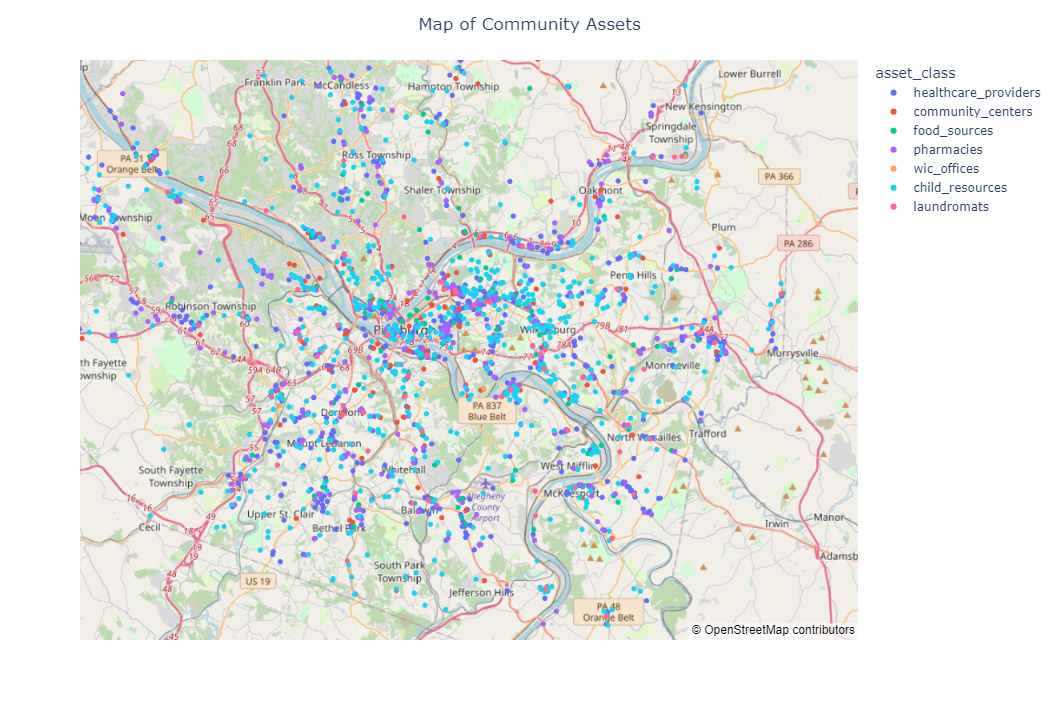

In [18]:
# Create a regular map of all the community assets, colored by asset_type
fig = px.scatter_mapbox(communityassets,lat='latitude',lon='longitude', hover_name="name", color='asset_class')
fig.update_layout(title = 'Map of Community Assets', title_x=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.show()